### 필요한 라이브러리 Import

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import re
import os
import io
import time
import random

import sentencepiece as spm

from tqdm.notebook import tqdm    # Process 과정을 보기 위해
import seaborn # Attention 시각화를 위해 필요!

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

print(tf.__version__)

2.4.1


### 데이터 다운로드 및 전처리

In [2]:
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [4]:
# 데이터 정제 및 토큰화
def get_df(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    df = pd.DataFrame(zip(kor, eng), columns = ["kor", "eng"])
    
    return df

In [5]:
df = get_df(kor_path, eng_path)

In [6]:
df.head()

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


* 중복제거

In [7]:
df.duplicated().value_counts()

False    78968
True     15155
dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

* 중복제거 후 길이 확인

In [9]:
len(df)

78968

* 중복처리 후 데이터 시각화

In [10]:
def corpus_len(df):
    corpus_kor_len = [len(token.split()) for token in df["kor"]]
    corpus_eng_len = [len(token.split()) for token in df["eng"]]
    return corpus_kor_len, corpus_eng_len

In [11]:
corpus_kor_len, corpus_eng_len = corpus_len(df)

In [12]:
def show_data(num_tokens):
    num_tokens = np.array(num_tokens)
    
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 최소 : ', np.min(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))
    
    max_len = np.max(num_tokens)
    
    plt.hist(num_tokens, bins = max_len, range=[0, max_len], facecolor='b')
    plt.show()

문장길이 평균 :  14.719240705095736
문장길이 최대 :  82
문장길이 최소 :  1
문장길이 표준편차 :  6.371726958851952


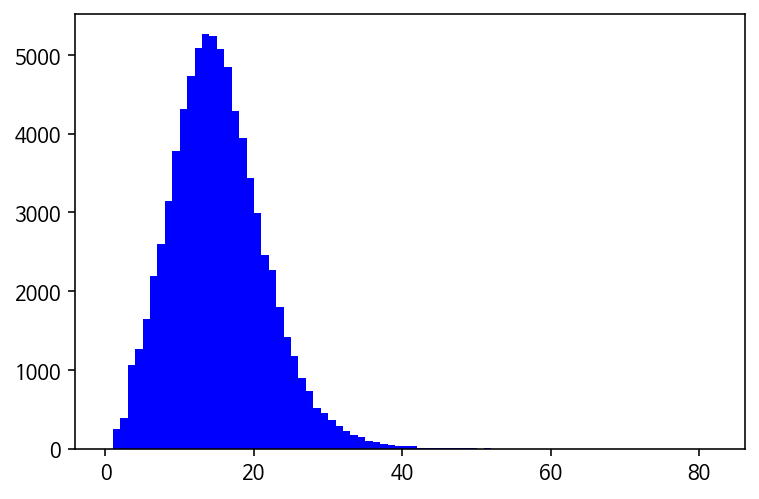

In [13]:
show_data(corpus_kor_len)

문장길이 평균 :  22.152340188430756
문장길이 최대 :  90
문장길이 최소 :  1
문장길이 표준편차 :  9.891886797733385


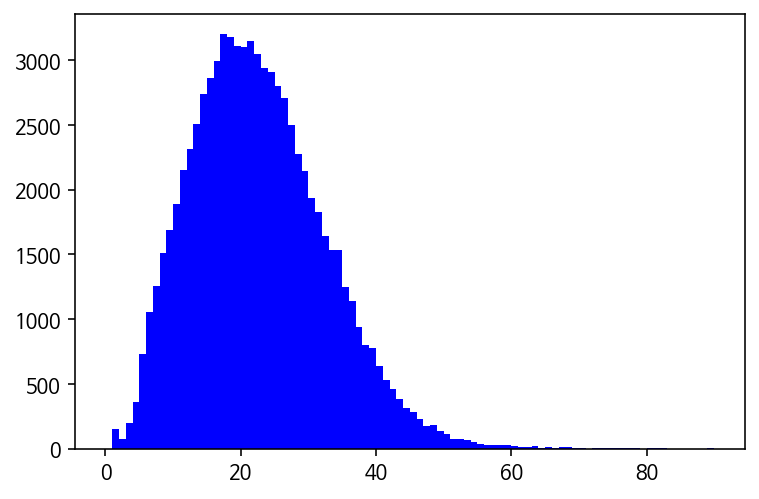

In [14]:
show_data(corpus_eng_len)

### 데이터 전처리

In [15]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()
        
    return sentence

In [16]:
df["kor"] = df["kor"].apply(preprocess_sentence)
df["eng"] = df["eng"].apply(preprocess_sentence)
df.head()

,kor,eng
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"like all optical mice , but it also doesn t ne..."
3,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,intelligence officials have revealed a spate o...


* 길이가 50이하인 문장만 남깁니다. 영어문장을 기준으로 했습니다.

In [17]:
df["len"] = df["eng"].apply(lambda x: len(x.split()))
df = df.loc[df["len"] <= 50]
print(len(df))

77308


### 토큰화
* 단어장의 길이는 20000으로 했습니다.

In [18]:
def generate_tokenizer(corpus, vocab_size, lang="ko"):
    
    temp_file = os.getenv('HOME')+f'/aiffel/transformer/{lang}.temp'
    vocab_size = vocab_size
    
    with open(temp_file, 'w', encoding='utf8') as f:
        for sen in corpus:
            f.write('{}\n'.format(sen))
            
    spm.SentencePieceTrainer.Train('--input={} --model_prefix=tokenizer_{} --vocab_size={} --model_type=unigram --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'.format(temp_file, lang, vocab_size))
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'tokenizer_{lang}.model')
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(df["kor"], SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(df["eng"], TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

* 패딩처리를 해줍니다.

In [19]:
enc_train = df["kor"].apply(ko_tokenizer.EncodeAsIds).tolist()
enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, padding='post')

dec_train = df["eng"].apply(en_tokenizer.EncodeAsIds).tolist()
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, padding='post')

### 모델 설계

* Positional_Encoding 구현

In [20]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

* Multihead_Attention 구현

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

* Position_wise_Feed_Forward_Network 구현

In [22]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

* Encoder 레이어 구현

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

* Decoder 레이어 구현

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

* Encoder 구현

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

* Decoder 구현

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

* Transformer 완성

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

* Masking 구현

In [28]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

* Learning Rate 구현 및 Optimizer 설정

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

* Loss 함수 정의

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 모델 학습

In [31]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

* 논문에 있는 파라미터를 참고했습니다.

In [32]:
transformer = Transformer(n_layers=2,  
                          d_model=512,
                          n_heads=8,
                          d_ff=2048,
                          src_vocab_size=SRC_VOCAB_SIZE,
                          tgt_vocab_size=TGT_VOCAB_SIZE,
                          pos_len=150,
                          dropout=0.2)

In [33]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [34]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [35]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [36]:
examples = ["오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."]

* 학습

In [37]:
BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                    dec_train[idx:idx+BATCH_SIZE],
                                                                    transformer,
                                                                    optimizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
    
    for sen in examples:
        translate(sen, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama said obama s .
Input: 시민들은 도시 속에 산다.
Predicted translation: they can be a lot of the city .
Input: 커피는 필요 없다.
Predicted translation: but it was not immediately .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed in the death toll .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is also around the world .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the largest city of the city .
Input: 커피는 필요 없다.
Predicted translation: you ve no one .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is deadly .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect is a president in the obama camp .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city of the city of the city of urban urban area .
Input: 커피는 필요 없다.
Predicted translation: but it needs to be a little very very , but it doesn t need to because it needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll at least one death , the death toll from the  ⁇  deaths .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a huge , he s going to be a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city city is a city of towns .
Input: 커피는 필요 없다.
Predicted translation: no one is no one .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama may be obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citys townsen in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were injured .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s shot is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets are about .
Input: 커피는 필요 없다.
Predicted translation: the coffee no one is a coffee shop .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the seventh fatality .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is the ap sha .
Input: 시민들은 도시 속에 산다.
Predicted translation: city citizens in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no one won .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents aren t happy .
Input: 커피는 필요 없다.
Predicted translation: then it s not too nice .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is marked a city in the city .
Input: 커피는 필요 없다.
Predicted translation: its demand is no longer departed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , officials said .


  0%|          | 0/1208 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city citizens in city
Input: 커피는 필요 없다.
Predicted translation: the coffee is not required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the main spot .


Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of president .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


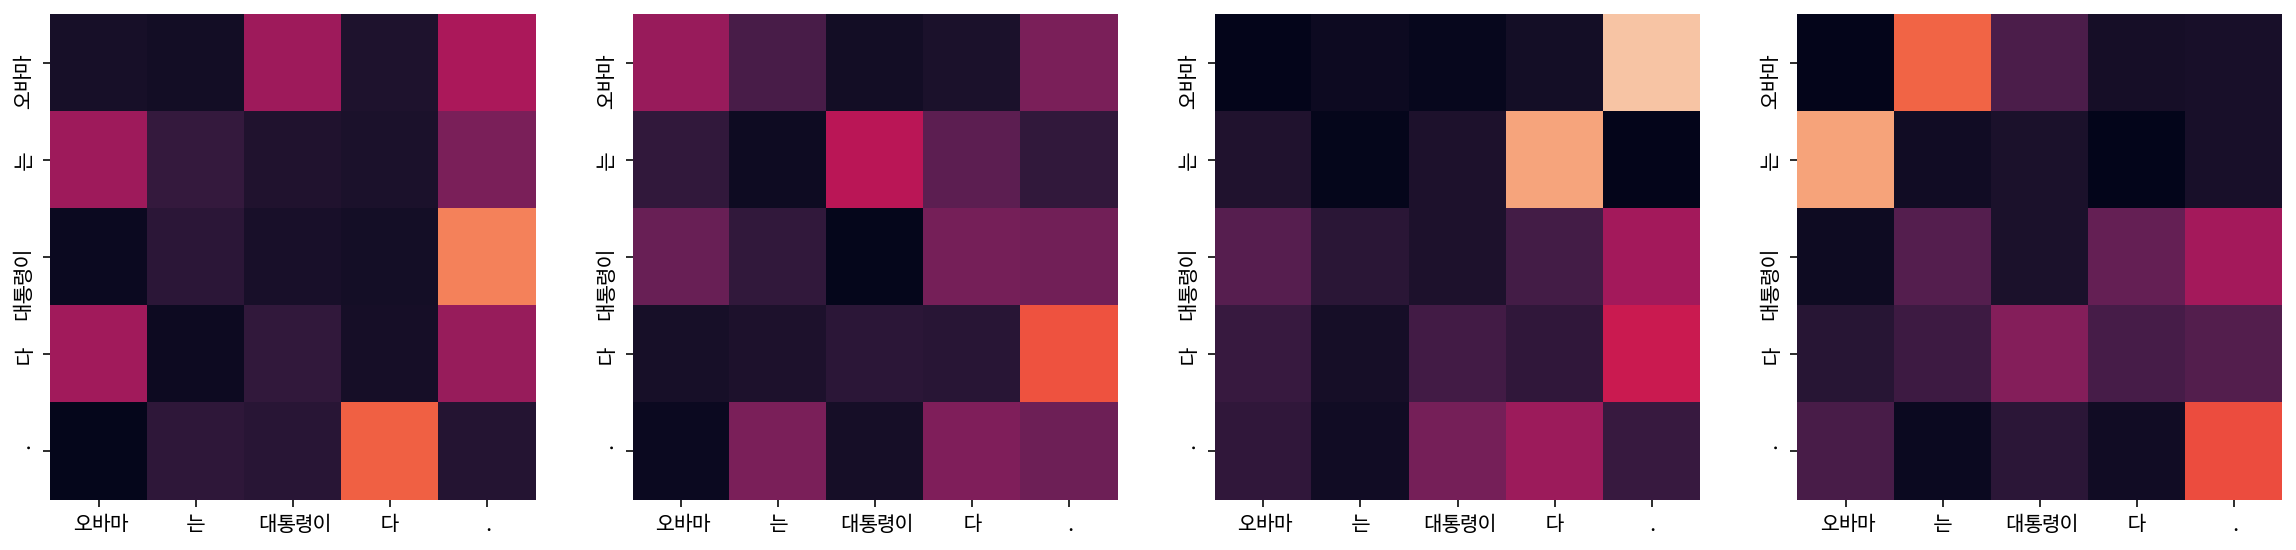

Encoder Layer 2


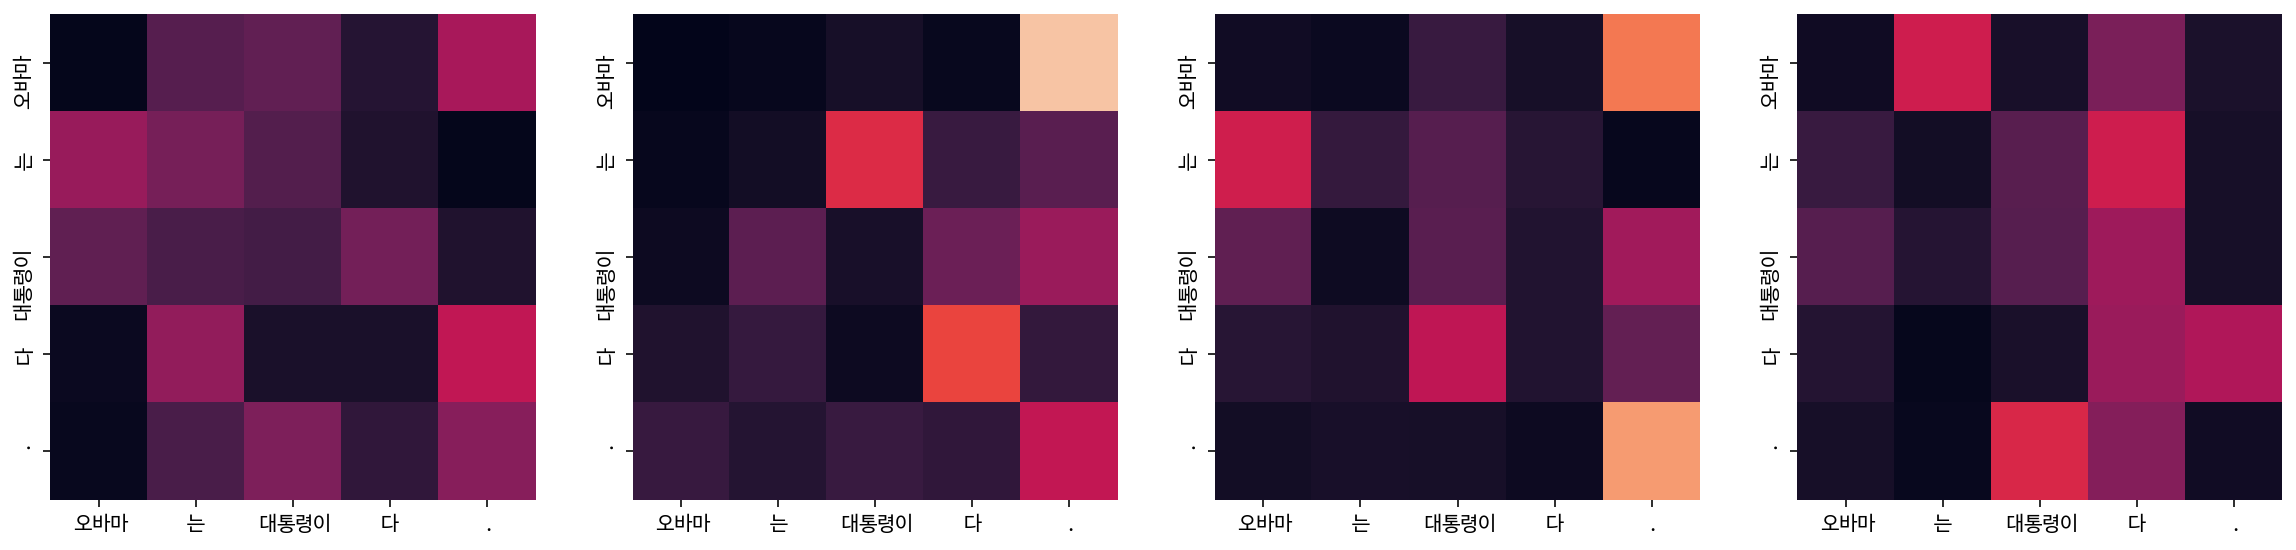

Decoder Self Layer 1


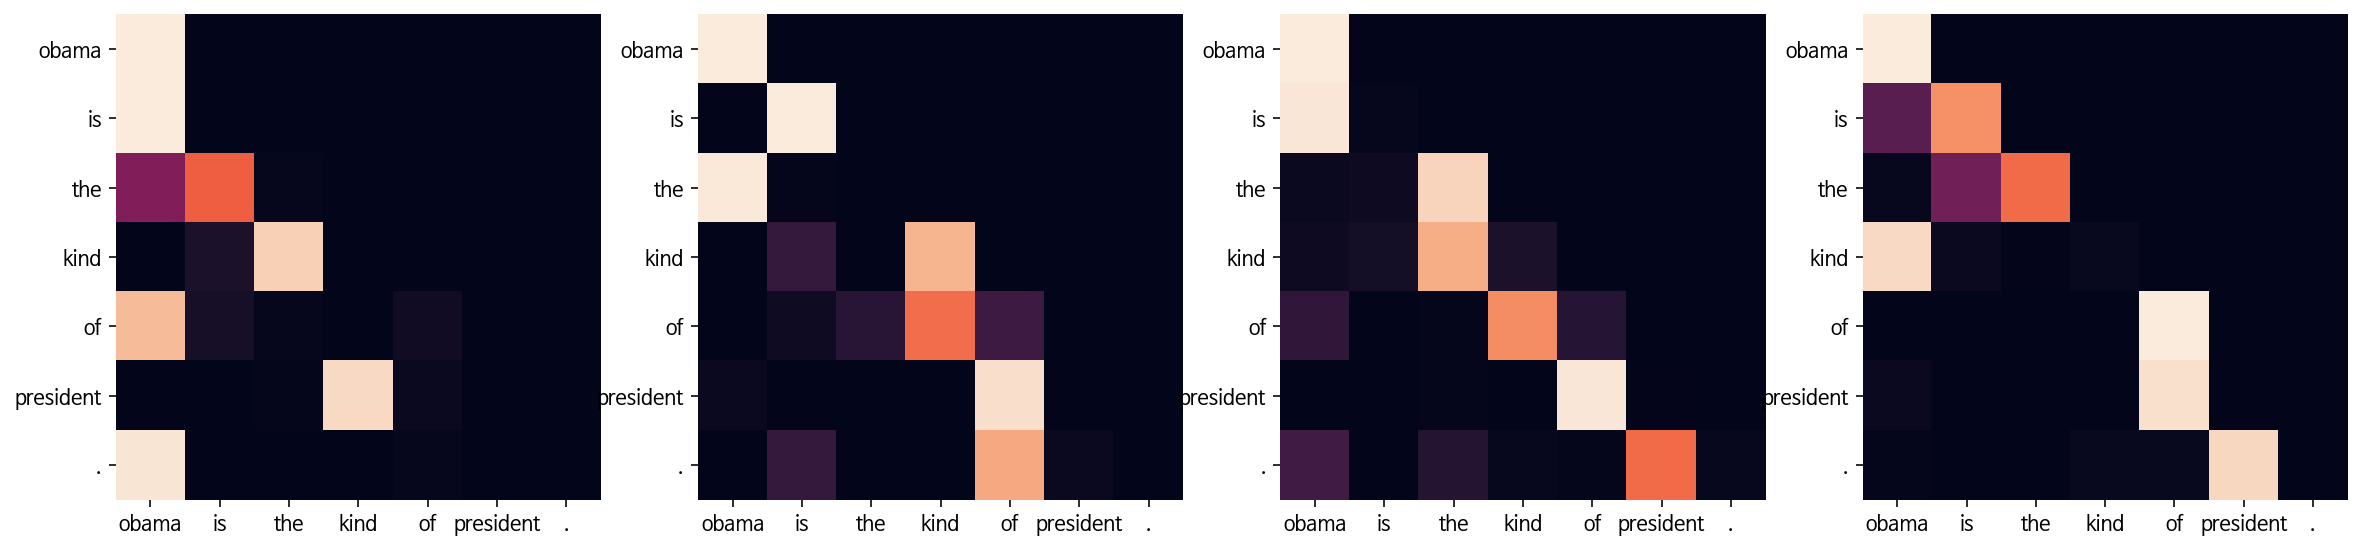

Decoder Src Layer 1


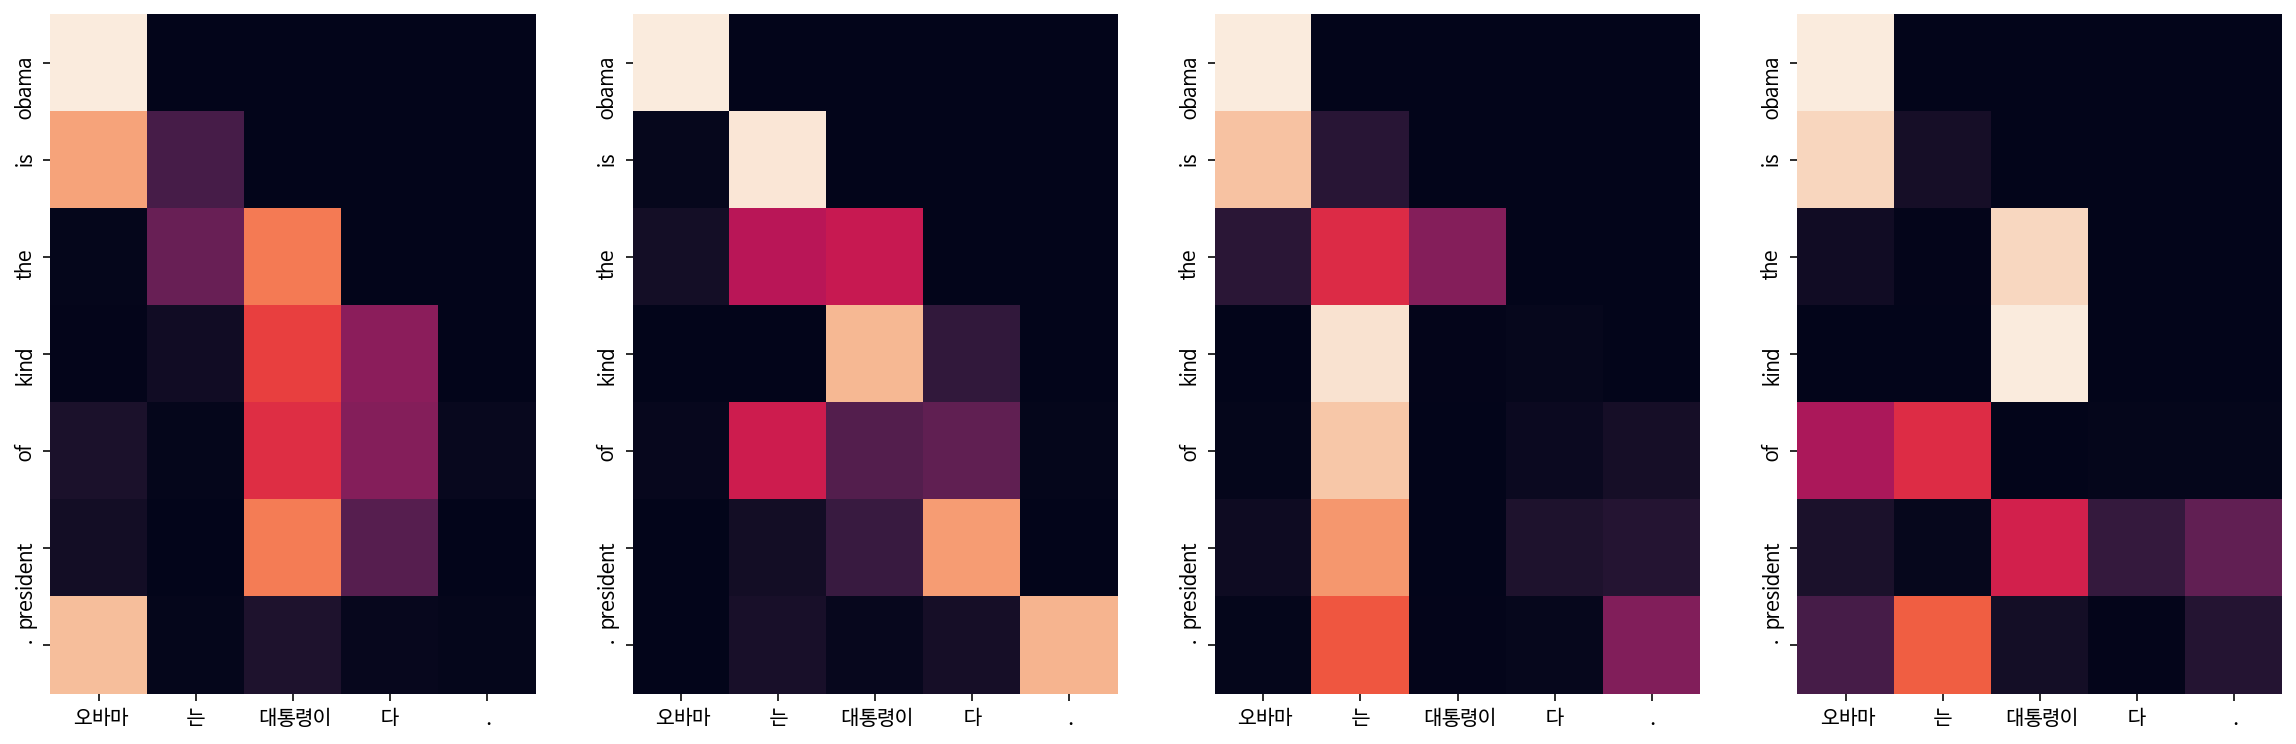

Decoder Self Layer 2


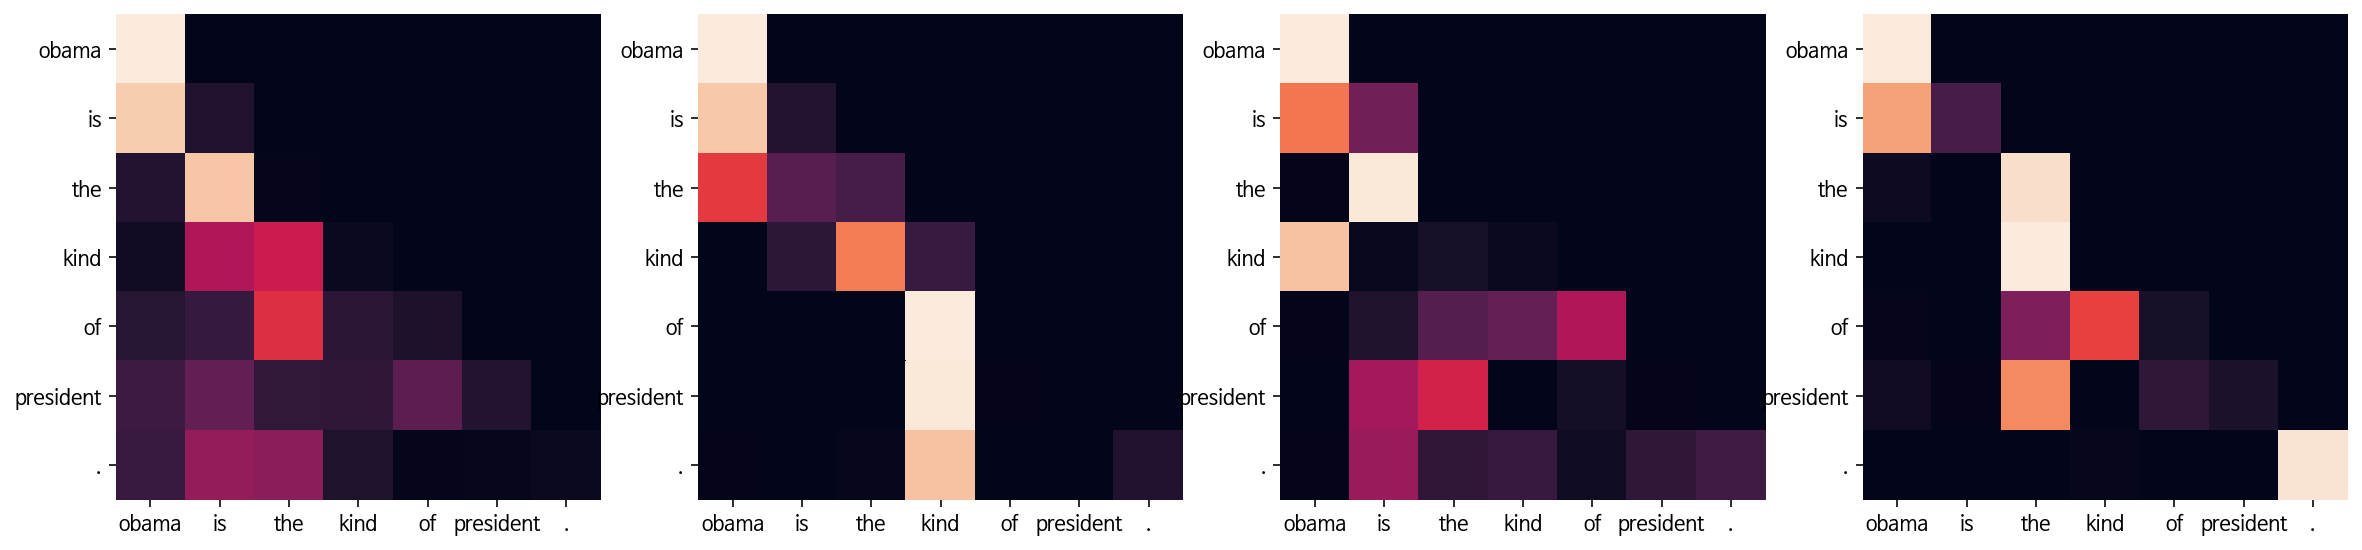

Decoder Src Layer 2


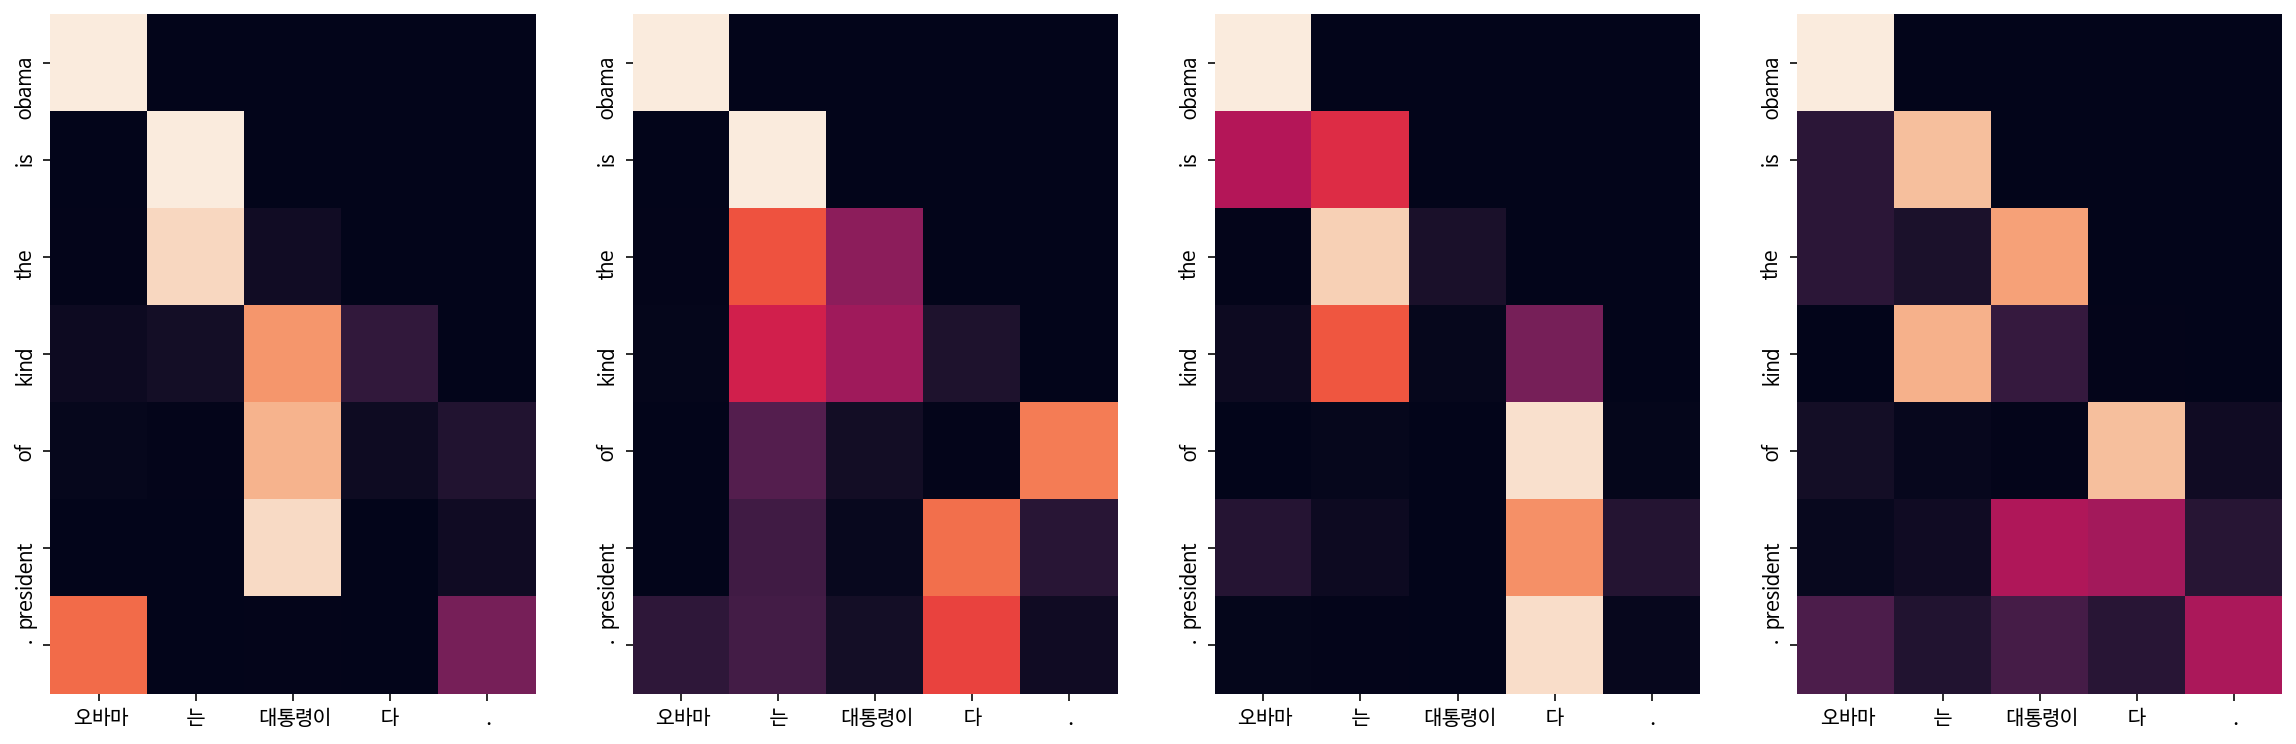

Input: 시민들은 도시 속에 산다.
Predicted translation: city citizens in city
Encoder Layer 1


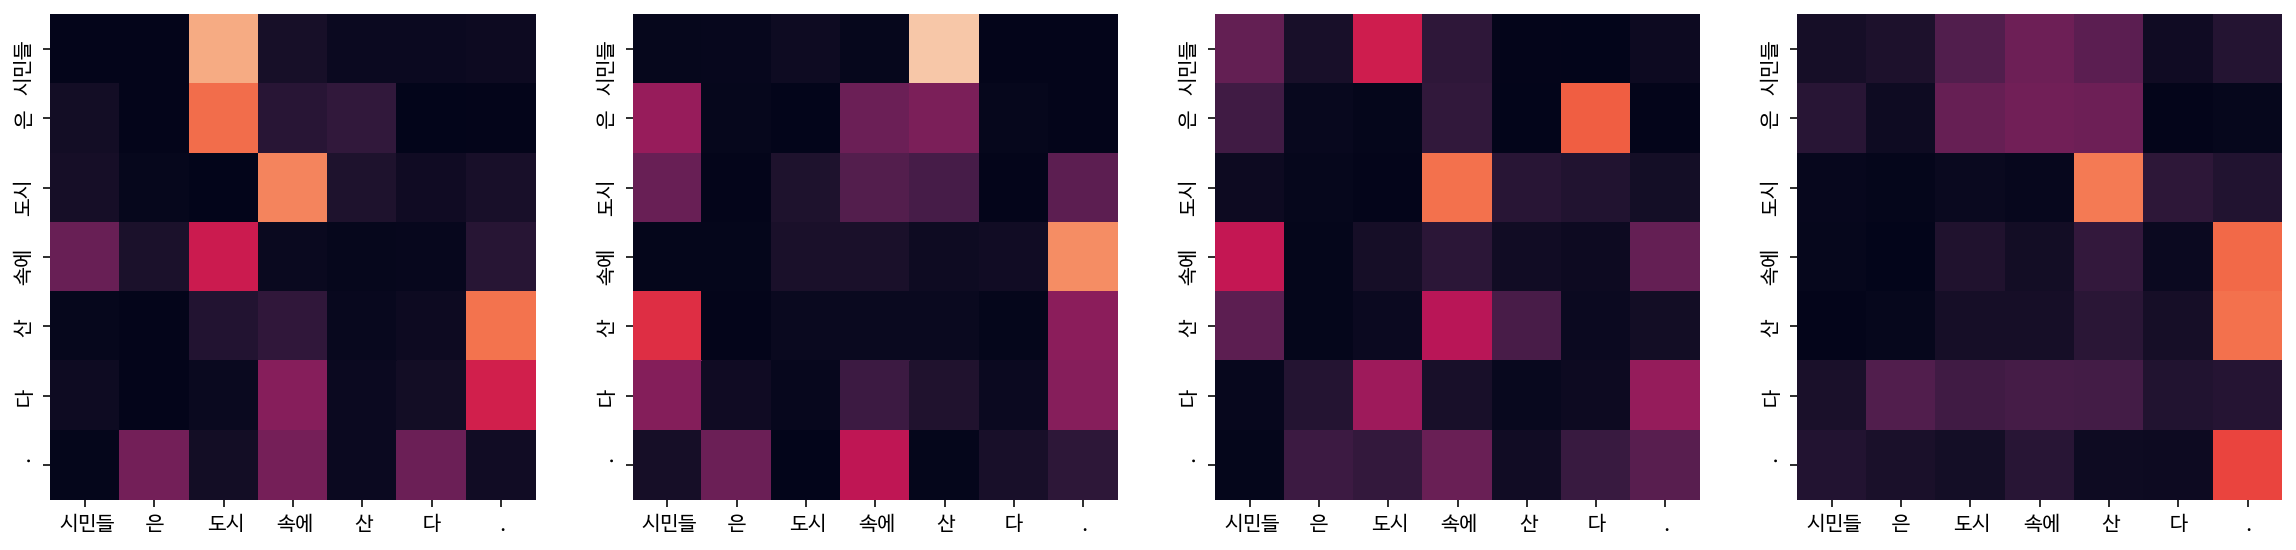

Encoder Layer 2


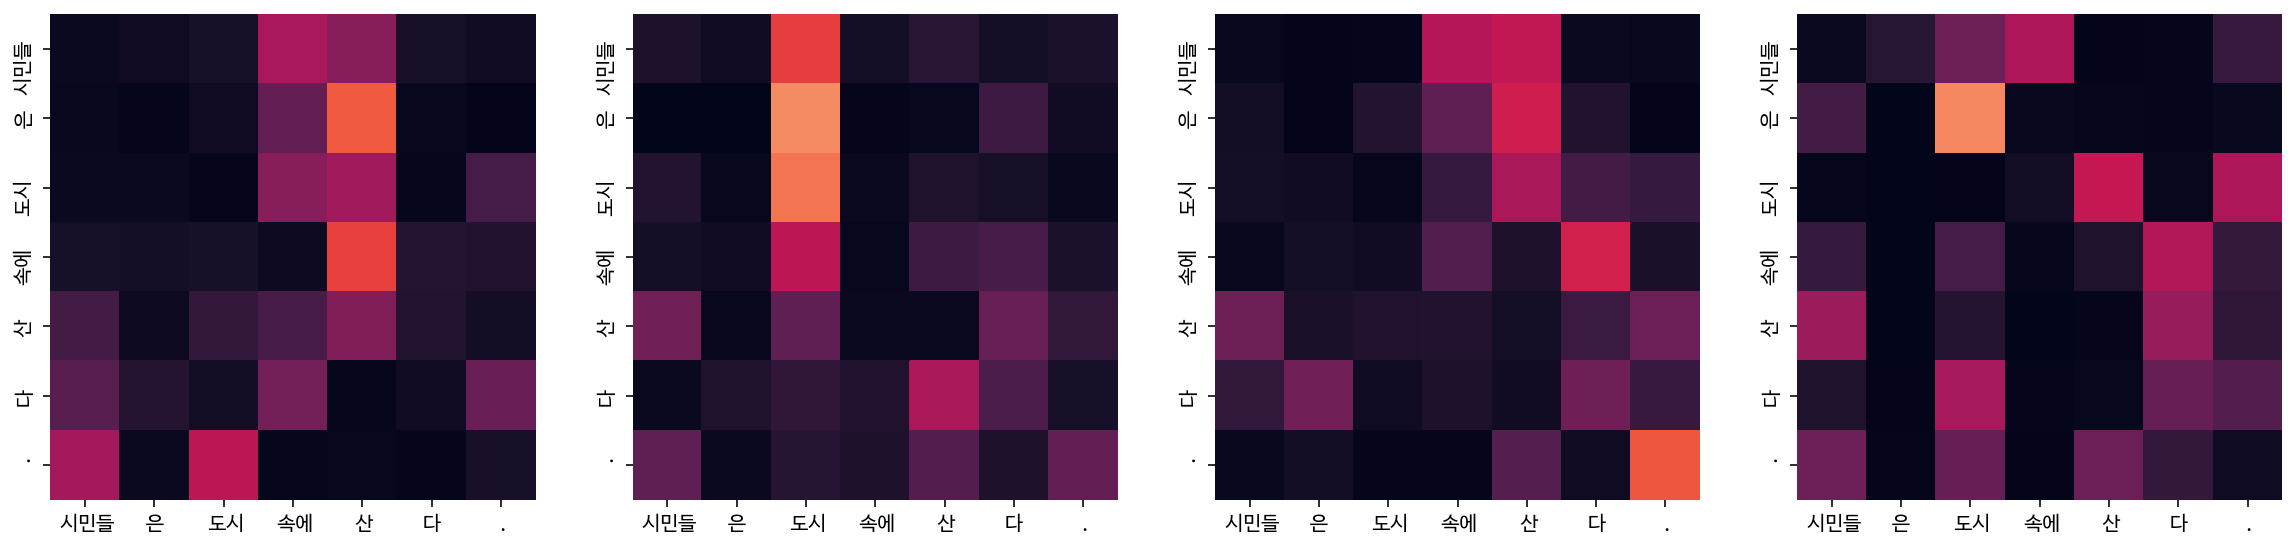

Decoder Self Layer 1


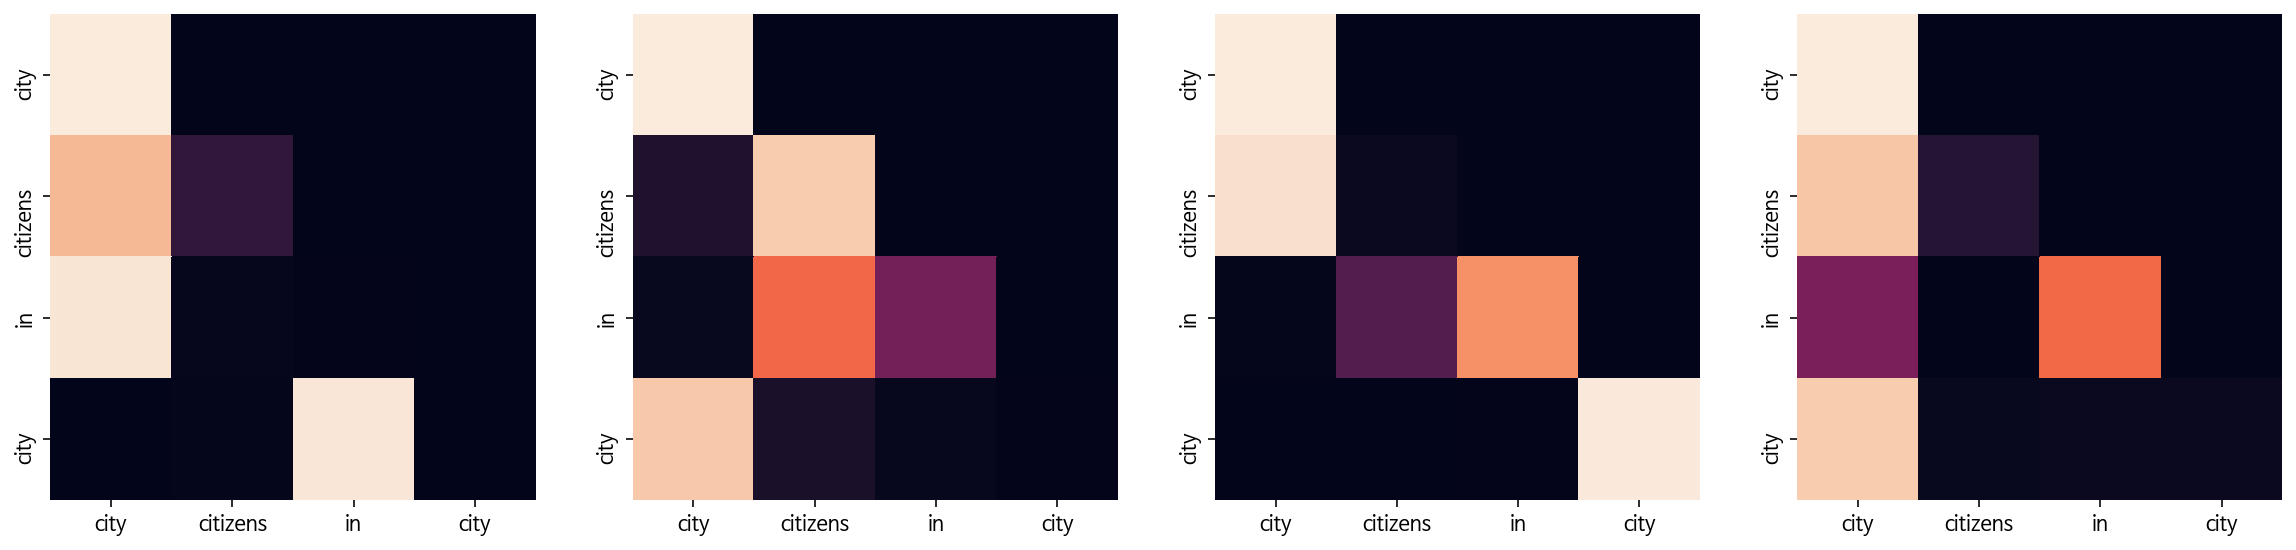

Decoder Src Layer 1


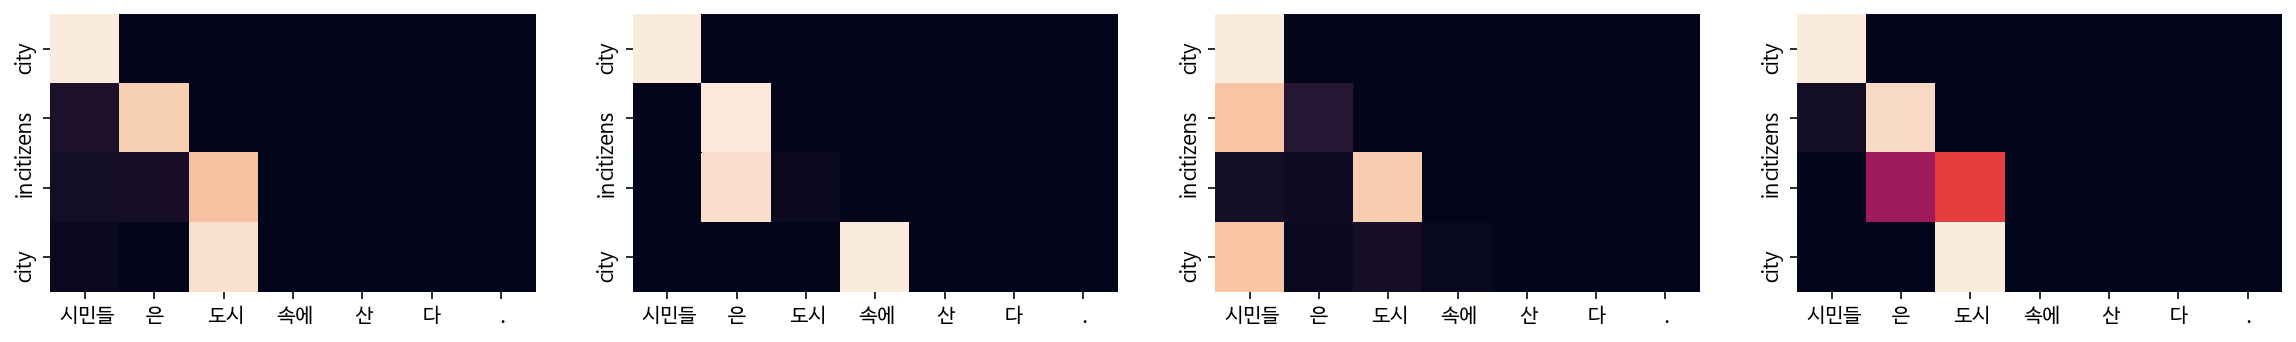

Decoder Self Layer 2


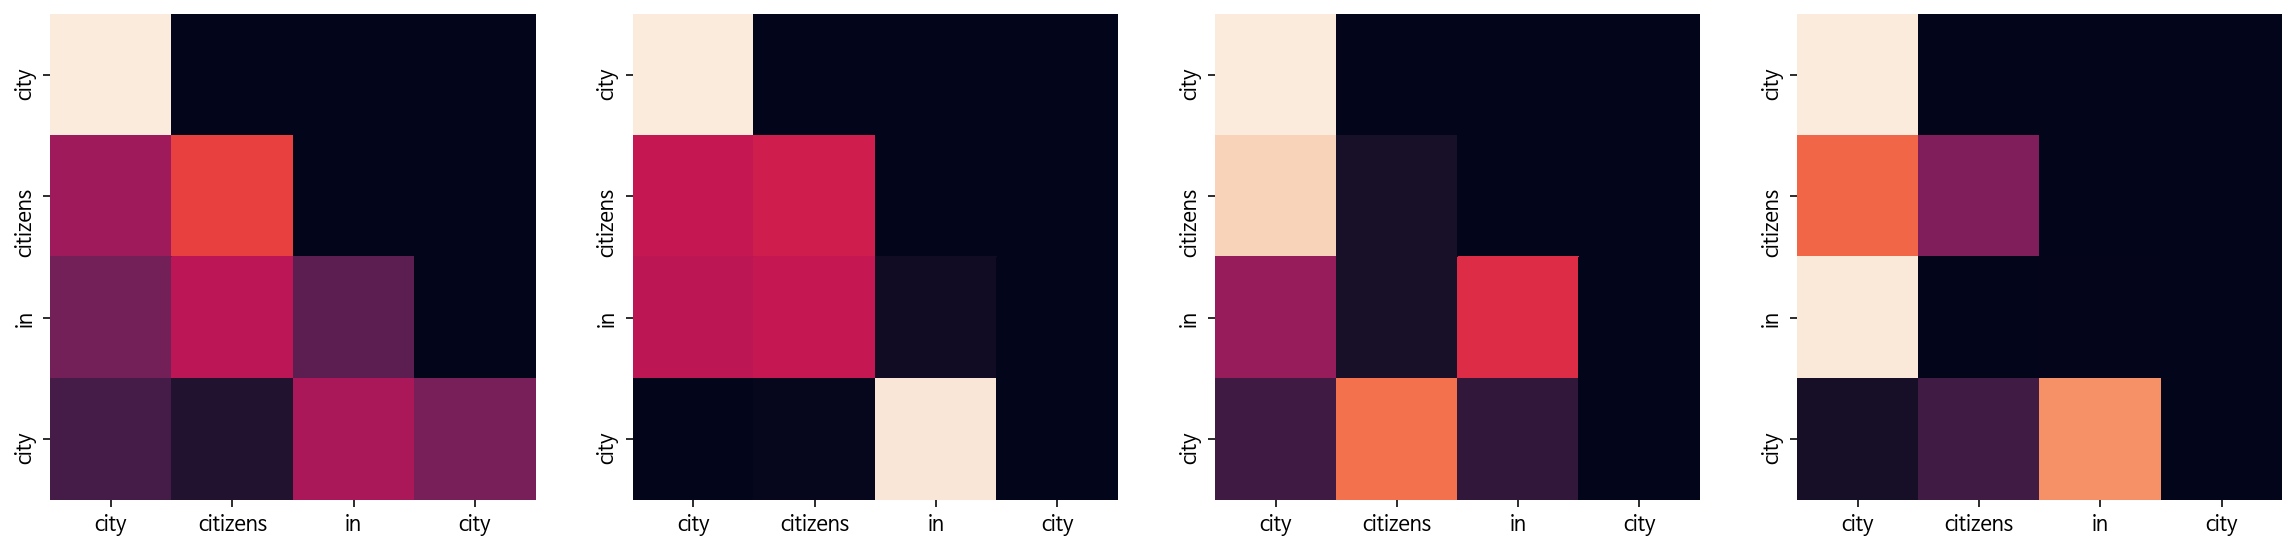

Decoder Src Layer 2


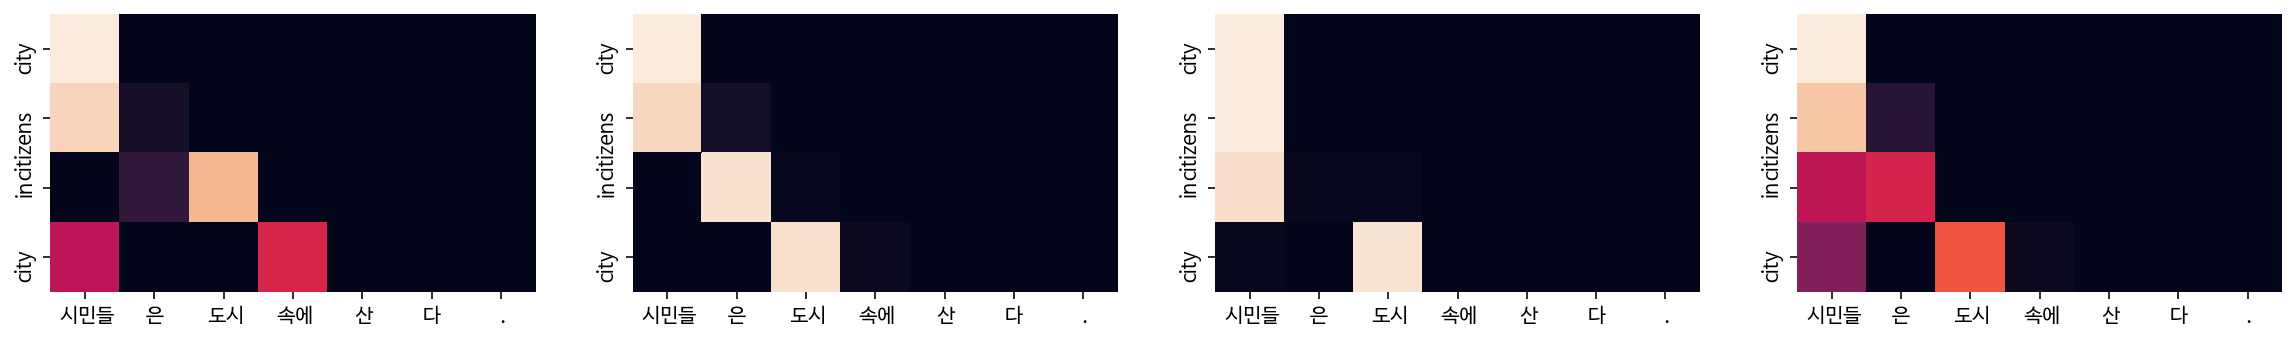

Input: 커피는 필요 없다.
Predicted translation: the coffee is not required .
Encoder Layer 1


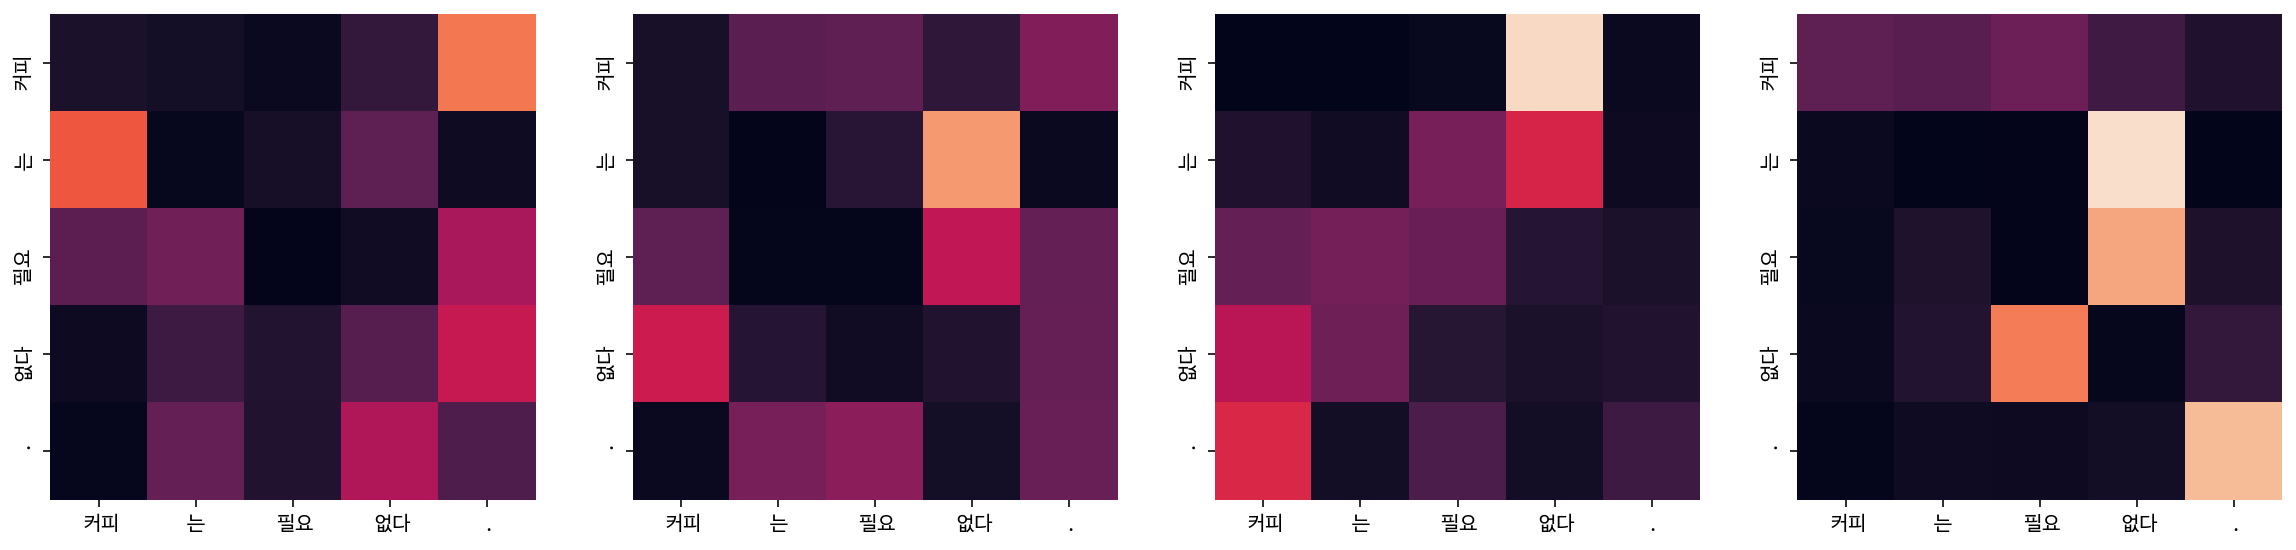

Encoder Layer 2


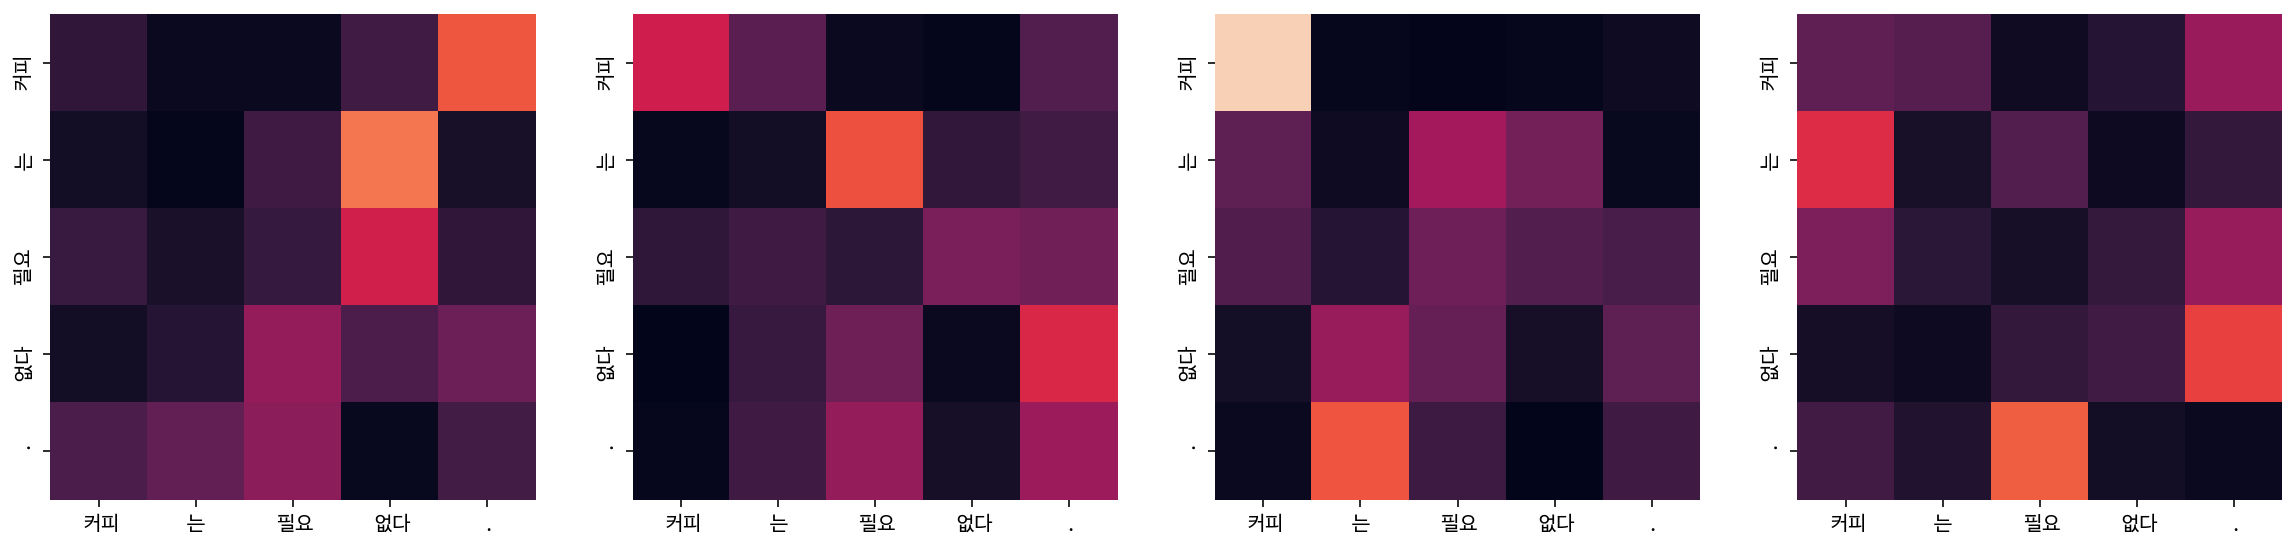

Decoder Self Layer 1


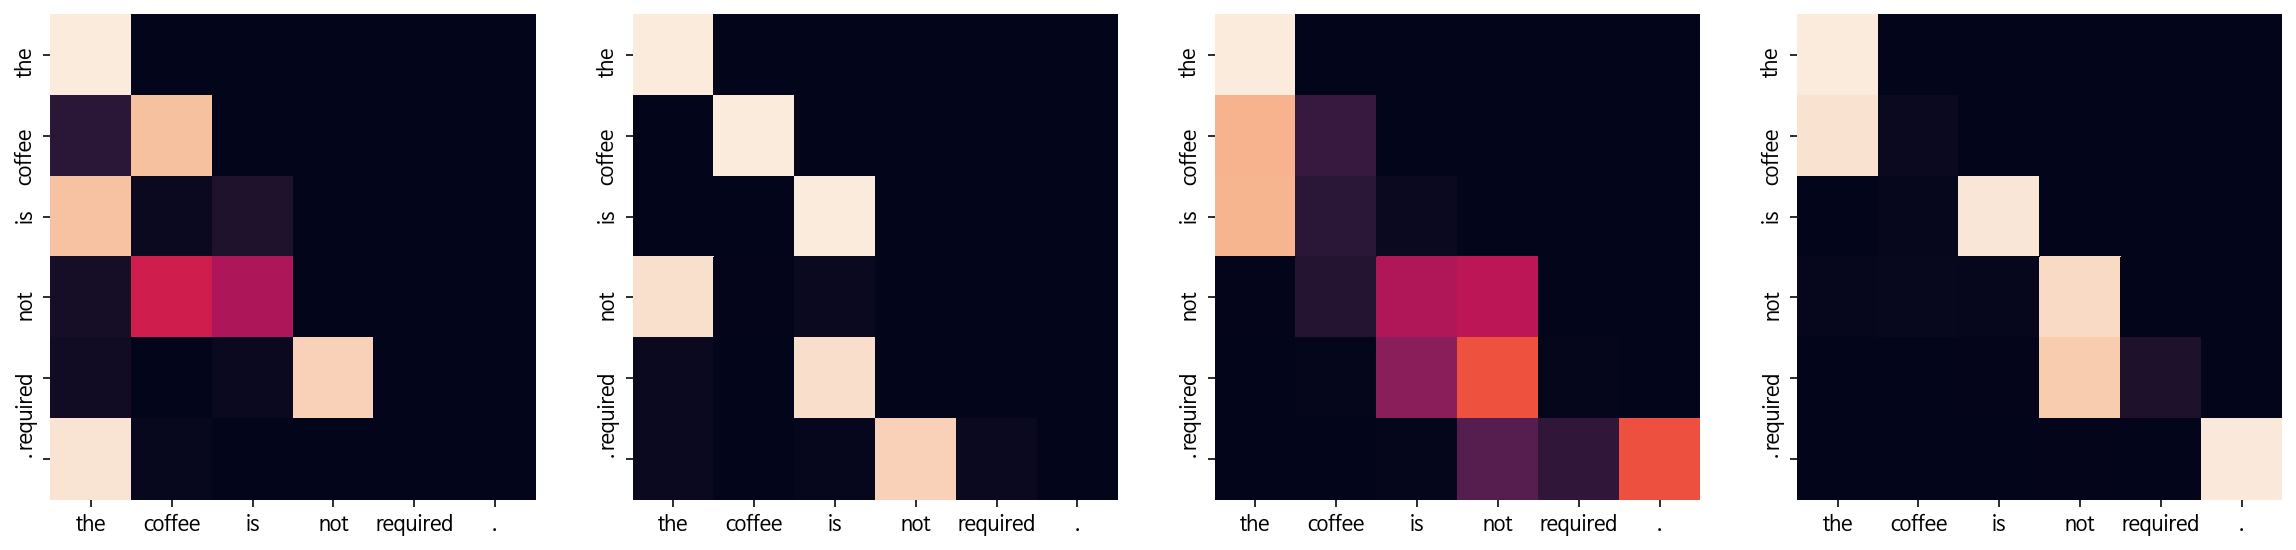

Decoder Src Layer 1


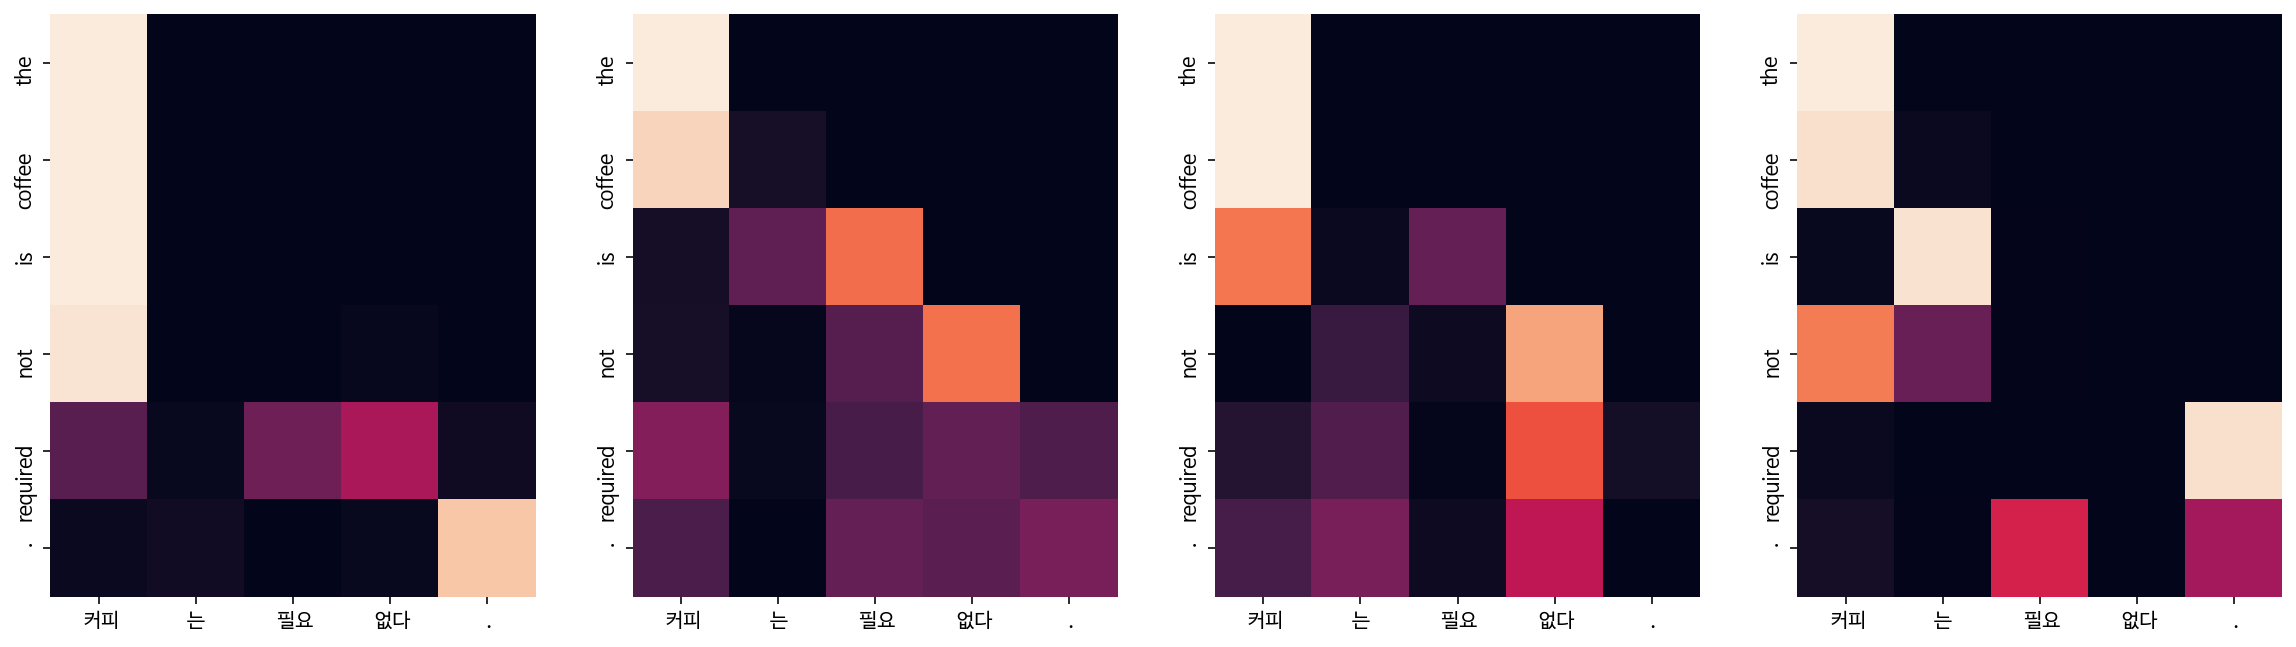

Decoder Self Layer 2


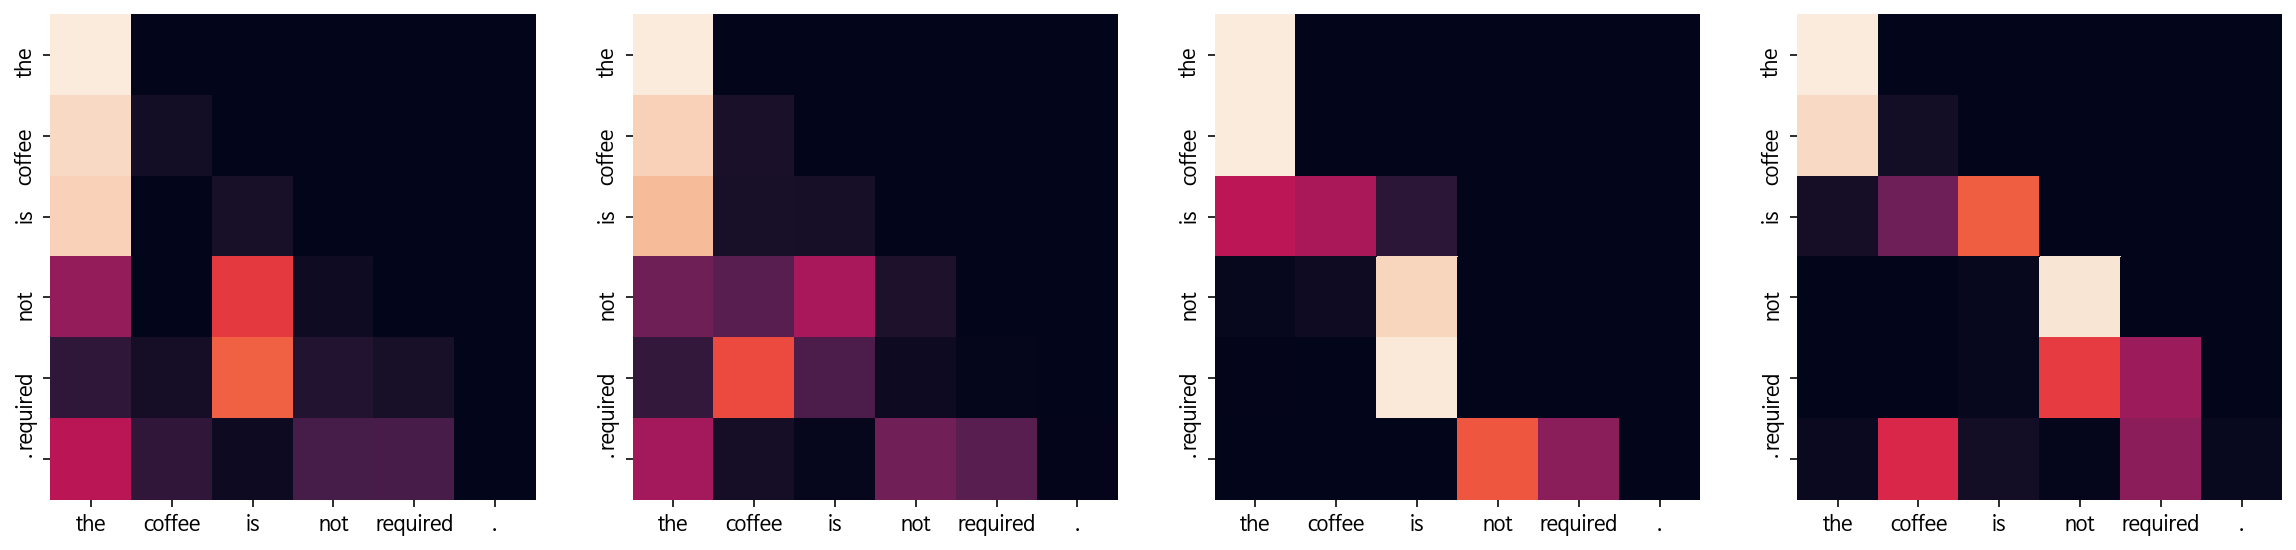

Decoder Src Layer 2


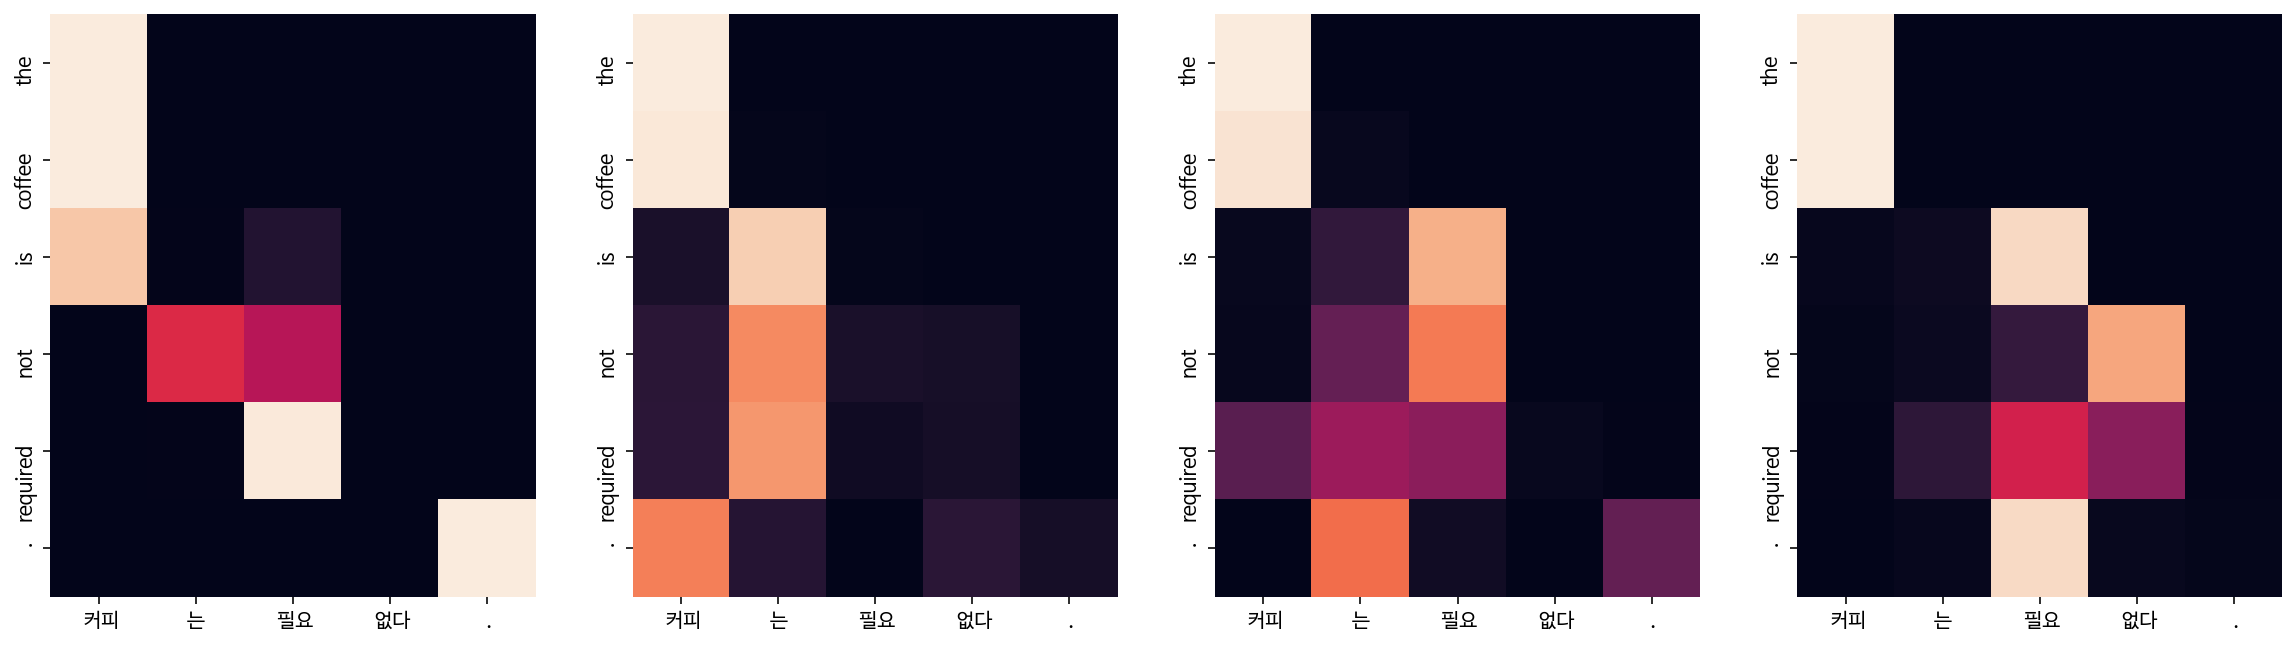

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , the main spot .
Encoder Layer 1


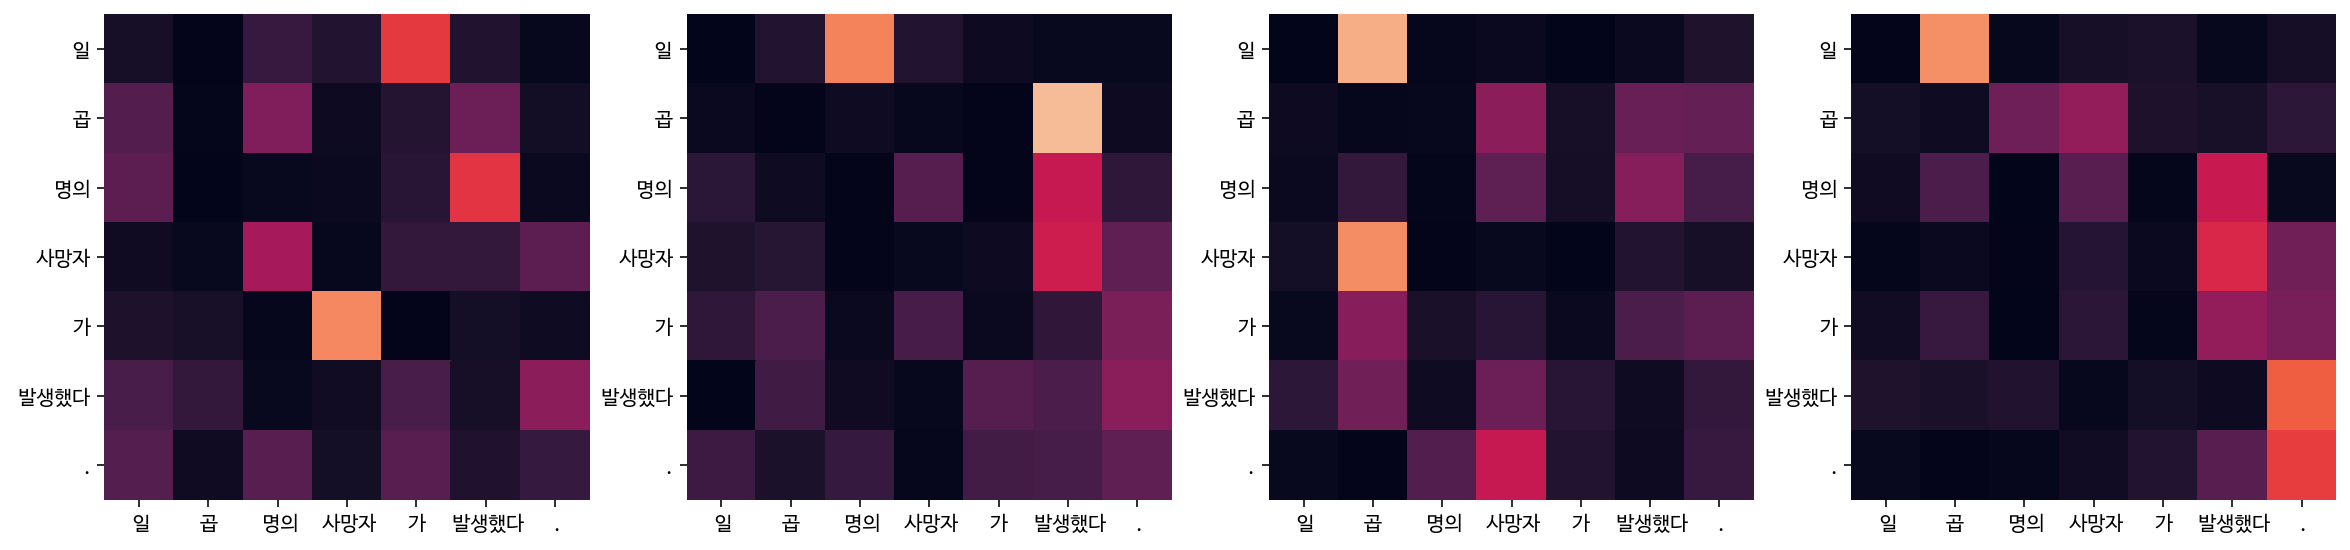

Encoder Layer 2


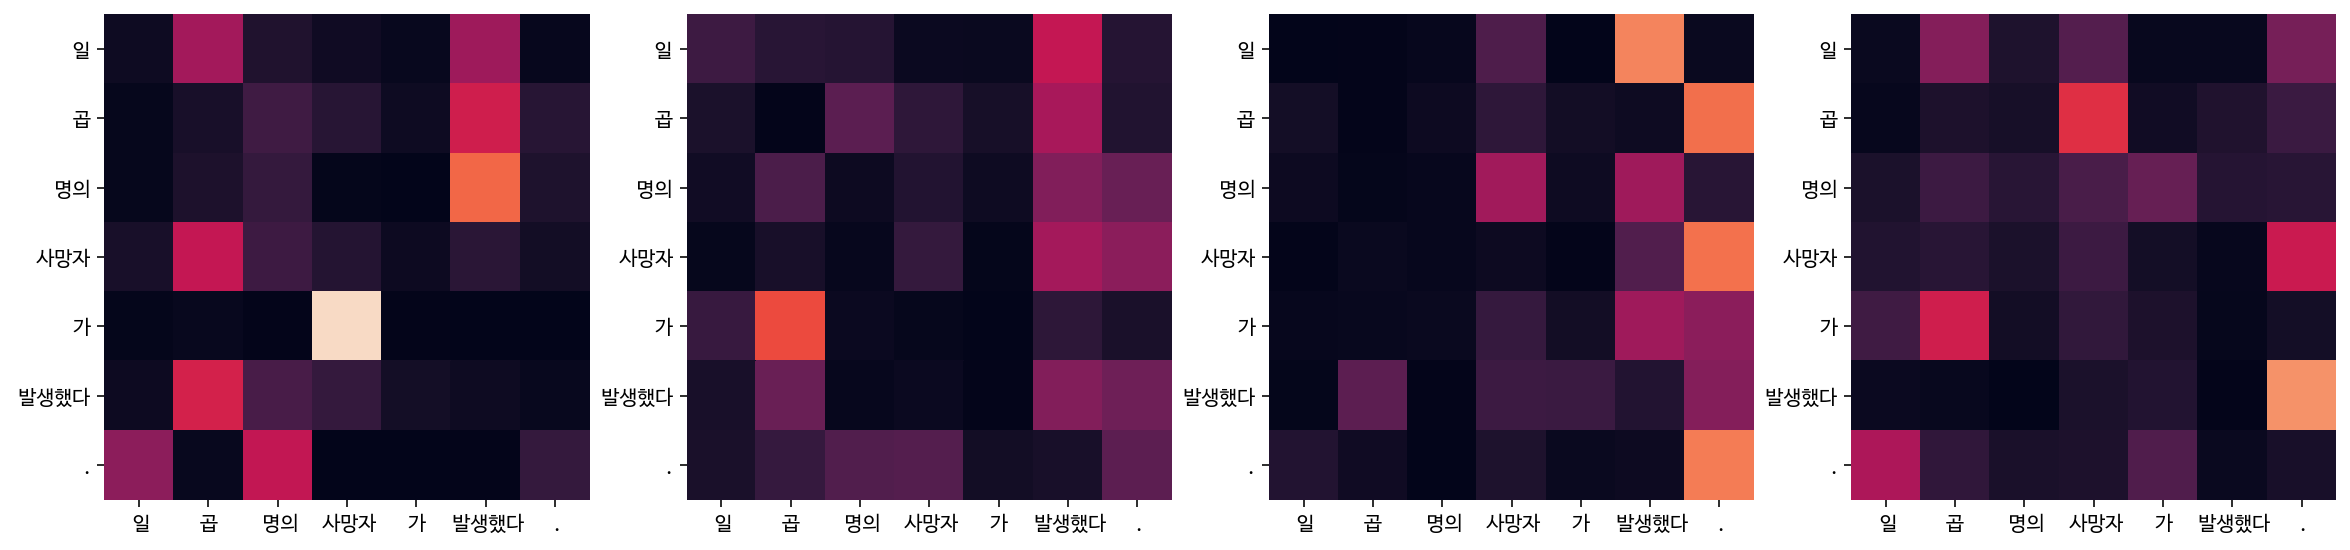

Decoder Self Layer 1


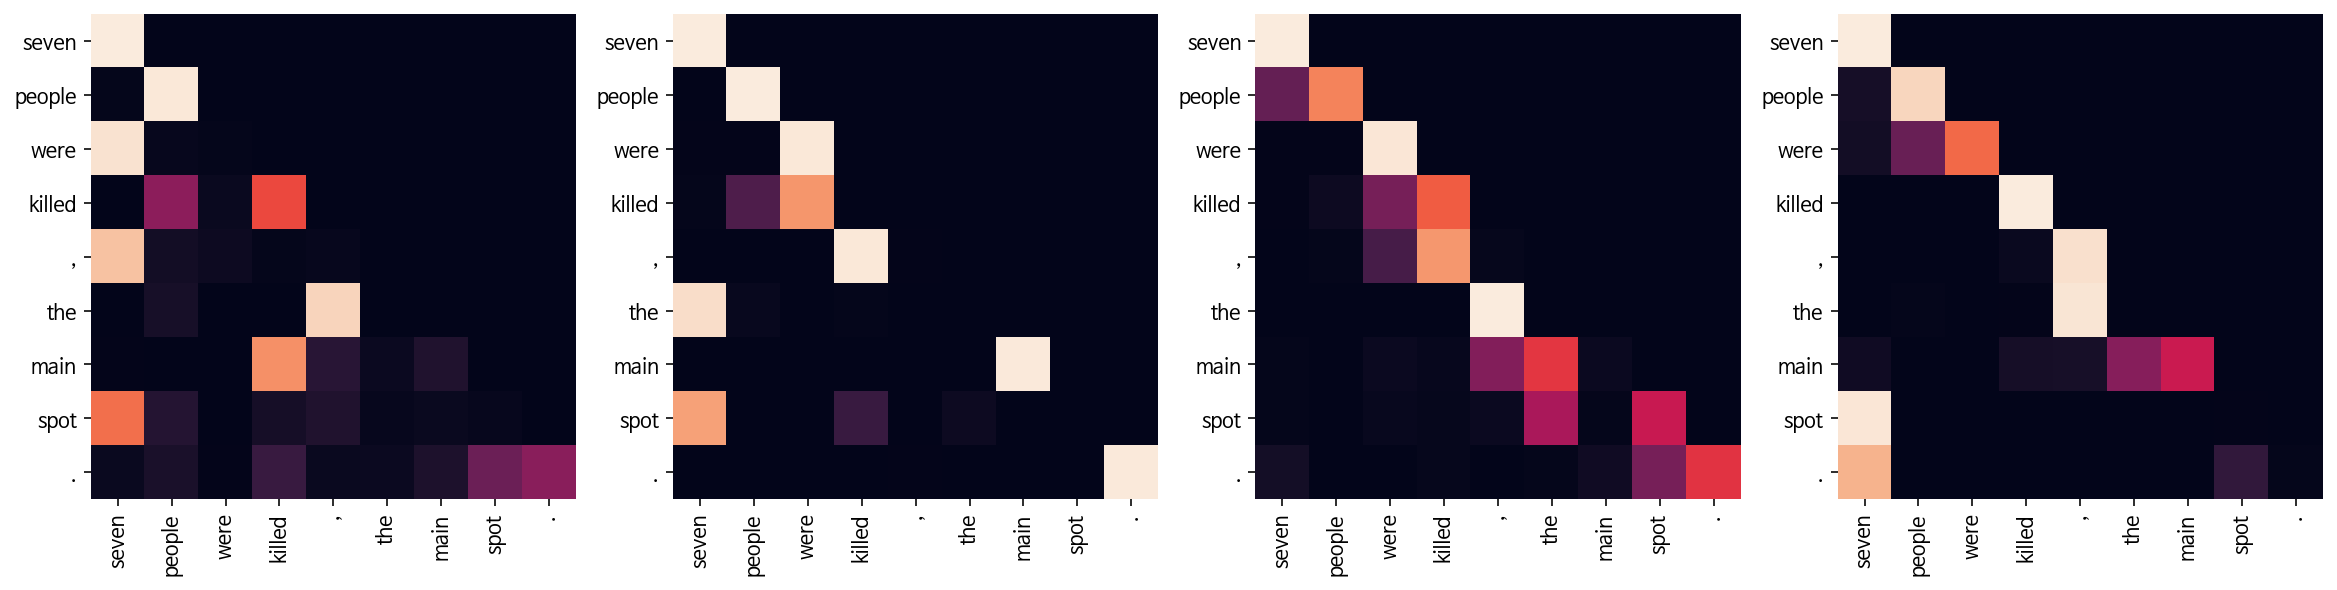

Decoder Src Layer 1


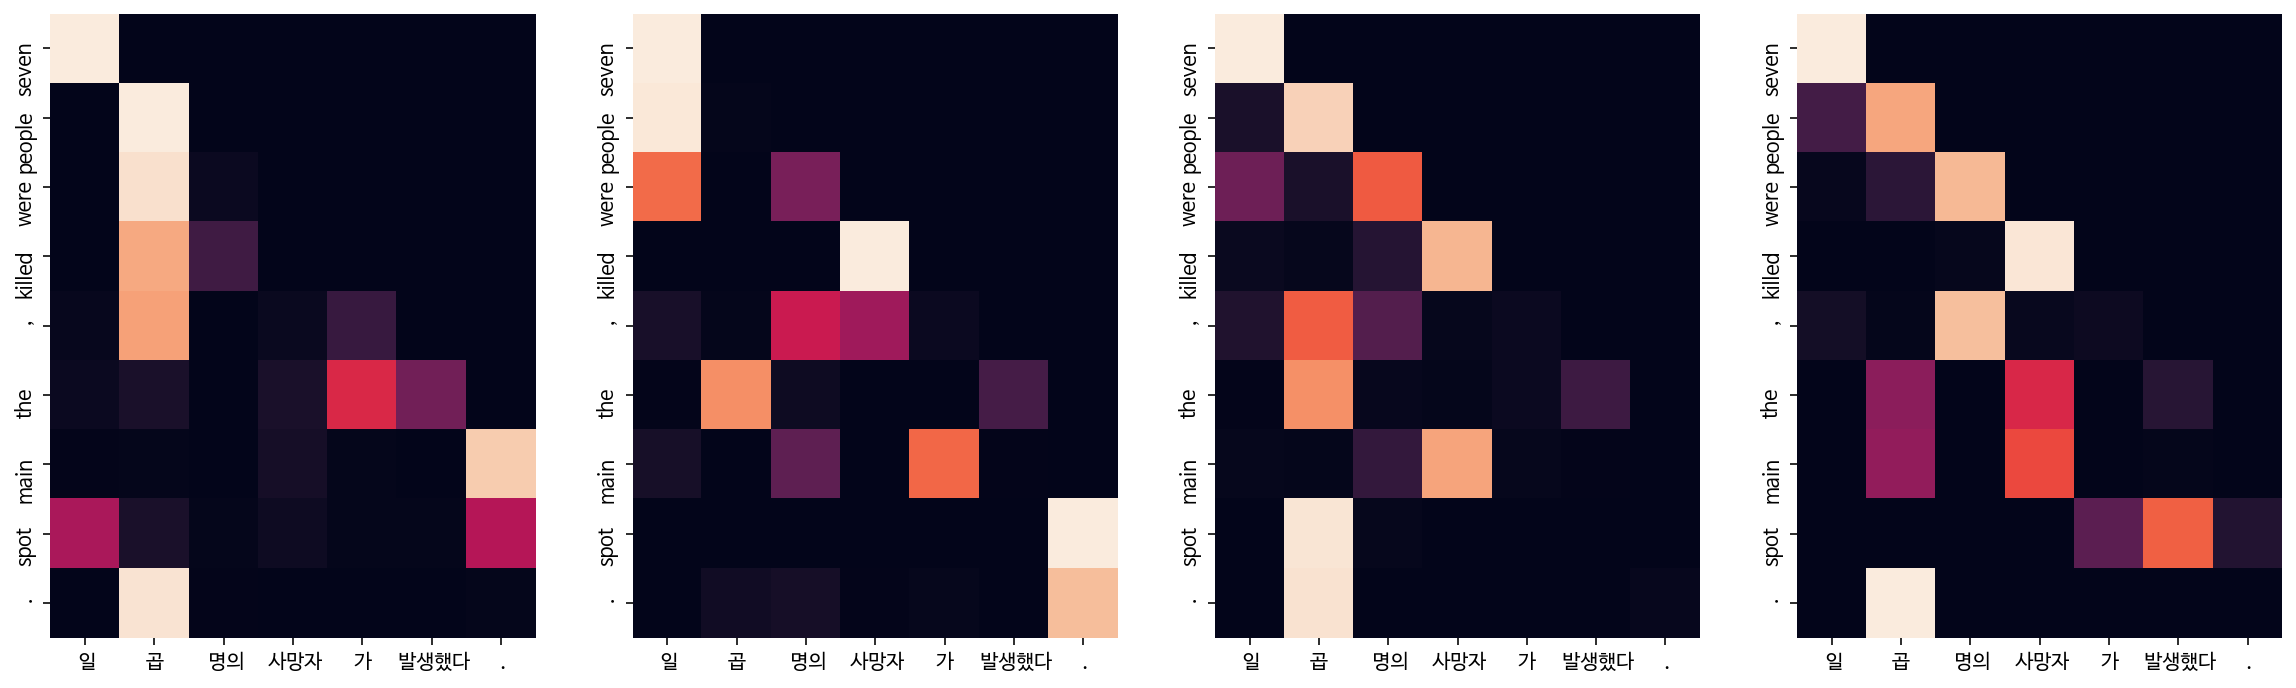

Decoder Self Layer 2


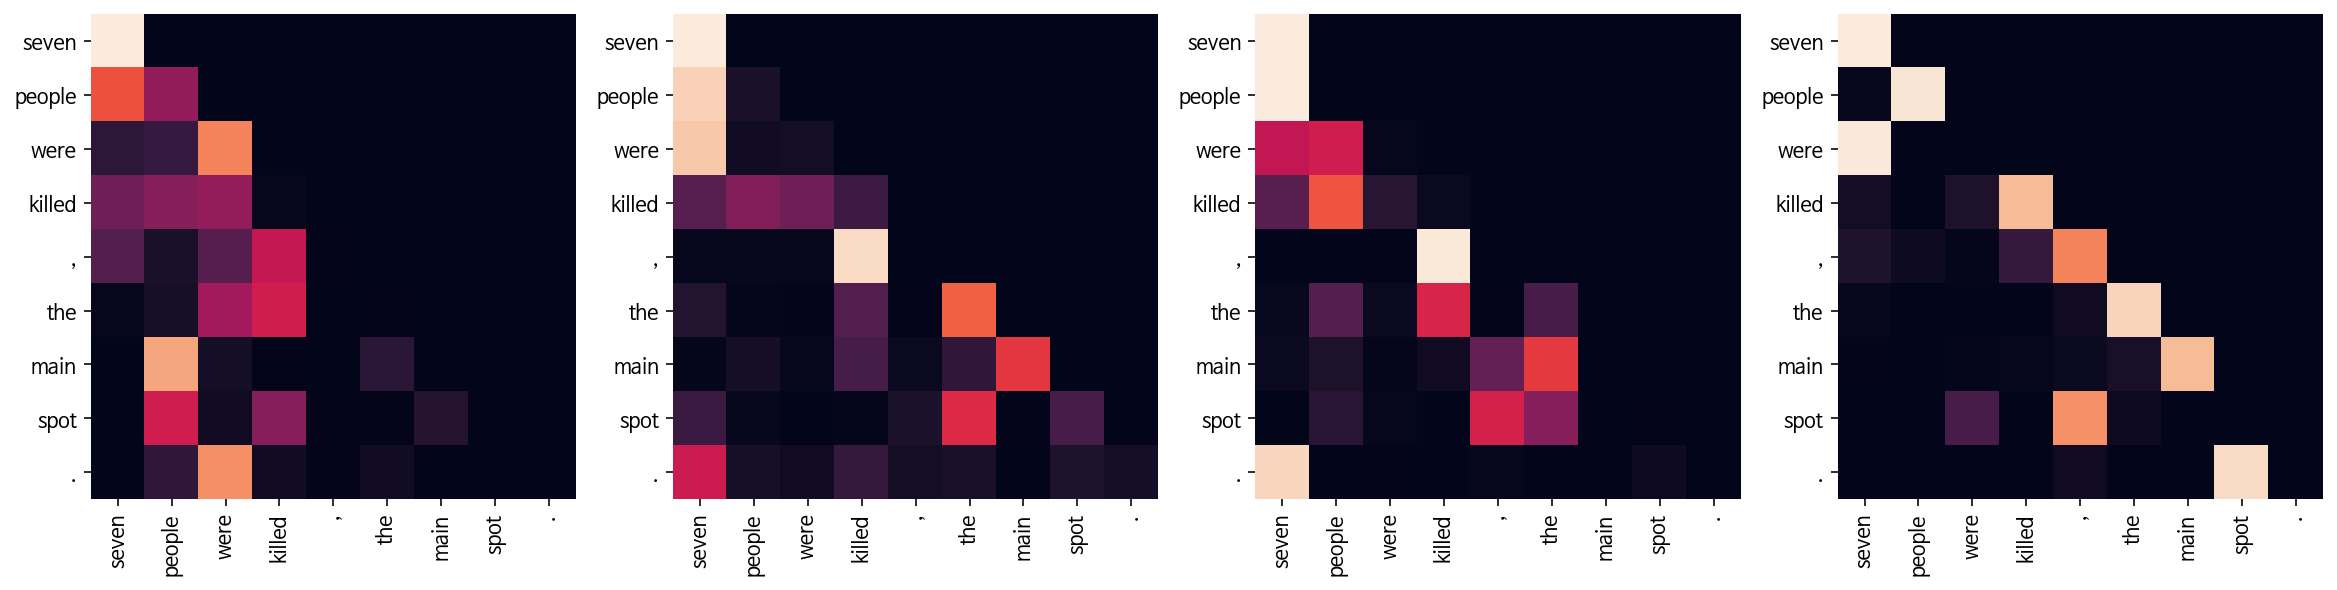

Decoder Src Layer 2


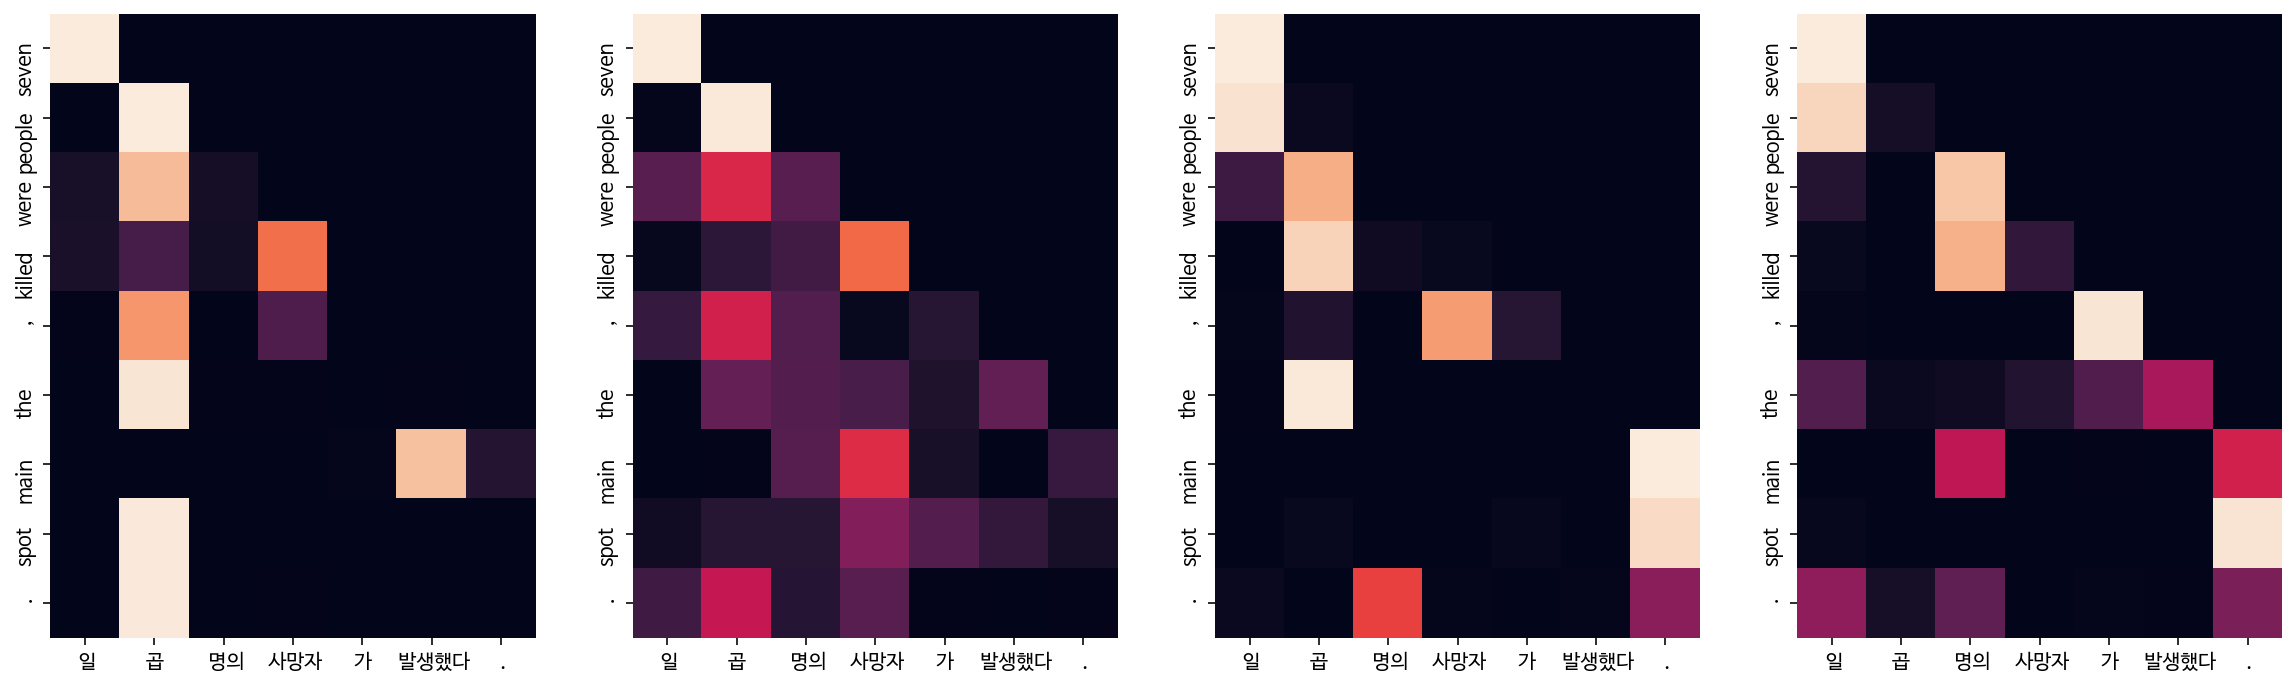

In [38]:
for sen in examples:
    translate(sen, transformer, ko_tokenizer, en_tokenizer, True)

### 결과표

|원문|번역|
|:----------------------:|:--------------------------:|
|오바마는 대통령이다|obama is the kind of president .|
|시민들은 도시 속에 산다.|city citizens in city|
|커피는 필요 없다.|the coffee is not required .|
|일곱 명의 사망자가 발생했다.|seven people were killed , the main spot .|

### 회고
* 처음엔 노드에 나와있는 코드로 전처리 및 토큰화를 하였는데, 다 하고나니 [GD8]에서 했던 방법이 좀더 좋은거 같아 바꿨습니다.
* 논문에 있는 파라미터를 처음 사용해서 학습했을때, 오류가 났는데 세션을 초기화후 다시 하니 정상적으로 작동했고, 처음 1에폭당 학습시간이 6시간이였는데 다시 초기화해서 실행하니 15분 이내로 학습이 되었습니다. 서버 문제였나 싶습니다.
* 프로젝트를 진행하면서 어텐션보다 성능이 매우 잘 나와서 놀랐고, 초기에 20에폭으로 진행했을때 15에폭쯤 부터 오버피팅이 일어나 번역이 아예 이상하게 진행되었습니다. 그래서 다시 10에폭으로 줄였더니 잘 번역하는것을 확인했습니다.